# **Sounding Out Parkinson's Disease**

# **1. Setup & Config**

In [ ]:
# ===== Section 1: Setup & Config =====

!pip -q install imbalanced-learn xgboost shap

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from typing import Dict, List, Tuple, Optional
from collections import Counter
import re

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, clone
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression as LR_L1

# Metrics
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, make_scorer
)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Explainability
import shap

# Global config
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ID_COL = "id"
TARGET_COL = "class"
POS_LABEL = 1  # PD = positive class
NEG_LABEL = 0  # Non-PD

# **2. Data Load & Exploration**

Our model will be trained and tested on tabular data acquired from a study gathering speech features from 188 patients with Parkinson's disease and 64 healthy individuals (Sakar et al., 2018). We accessed the data on [Kaggle](https://www.kaggle.com/datasets/dipayanbiswas/parkinsons-disease-speech-signal-features?resource=download).

Original Dataset from UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/470/parkinson+s+disease+classification.

In [ ]:
# ===== Section 2: Load Dataset & Quick EDA =====

import kagglehub

# Download latest version
path = kagglehub.dataset_download("dipayanbiswas/parkinsons-disease-speech-signal-features")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'parkinsons-disease-speech-signal-features' dataset.
Path to dataset files: /kaggle/input/parkinsons-disease-speech-signal-features


In [ ]:
csv_path = "/kaggle/input/parkinsons-disease-speech-signal-features/pd_speech_features.csv"
df_raw = pd.read_csv(csv_path)
df_raw.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


Dataset contains:

*   0 null values
*   252 unique speakers
*   756 rows
*   755 numerical features

In [ ]:
# Basic checks
assert ID_COL in df_raw.columns, f"Expected '{ID_COL}' column."
assert TARGET_COL in df_raw.columns, f"Expected '{TARGET_COL}' column."

print("Null values:", df_raw.isna().sum().sum())
print("Unique speakers:", df_raw[ID_COL].nunique())

print("\nDataset Info:")
df_raw.info()

Null values: 0
Unique speakers: 252

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


Class Imbalance present within the Target class


*   Non-PD : PD ratio is approximately 1 : 3



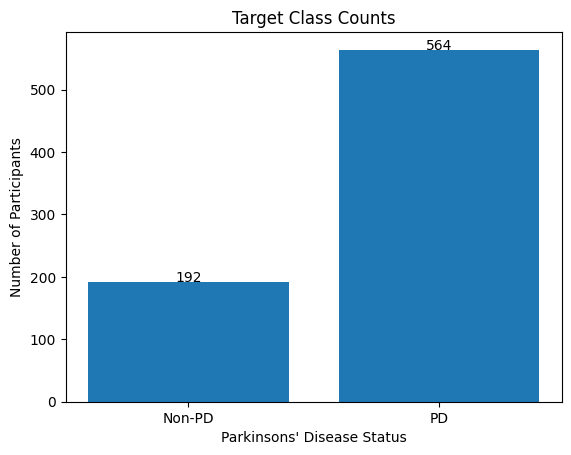

In [ ]:
# Target classes: Parkinson's participants = 1, Healthy participants = 0
target_freq = df_raw[TARGET_COL].value_counts()
target_class = [target_freq[0], target_freq[1]]

# Show distribution of feature correlation values with the target variable
labels = ["Non-PD", "PD"]
plt.bar(labels, target_class)
plt.xlabel("Parkinsons' Disease Status")
plt.ylabel("Number of Participants")
plt.title(f"Target Class Counts")

def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center')  # Aligning text at center

# Adding value labels
add_labels(labels, target_class)

Gender imbalance present within each Target class

  Approximate Male: Female ratios within each class:
*   PD -->  1.3 : 1
*   Non-PD --> 1 : 2



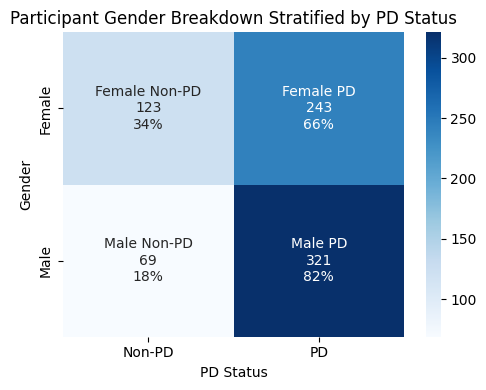

In [ ]:
# Gender by target class
gender_target_matrix = pd.crosstab(df_raw['gender'], df_raw[TARGET_COL])

# Normalize row-wise
gender_target_matrix_norm = pd.crosstab(df_raw['gender'], df_raw[TARGET_COL], normalize='index')

# Square labels
group_names = ["Female Non-PD","Female PD","Male Non-PD", "Male PD"]
group_counts = gender_target_matrix.values.flatten()
group_percentages = ["{0:.0%}".format(value) for value in gender_target_matrix_norm.values.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Plot the matrix
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(gender_target_matrix, annot=labels, fmt='', cmap="Blues")

# Axis labels
ax.set_title("Participant Gender Breakdown Stratified by PD Status")
ax.set_xlabel("PD Status")
ax.set_ylabel("Gender")
ax.set_xticklabels(["Non-PD", "PD"])
ax.set_yticklabels(["Female", "Male"])

# Display
plt.tight_layout()
plt.show()

There are no features with correlation values over 0.5, so the model will rely on multiple features to make classifications.

Text(0.5, 1.0, 'Histogram of Feature Correlation Absolute Values with the Target')

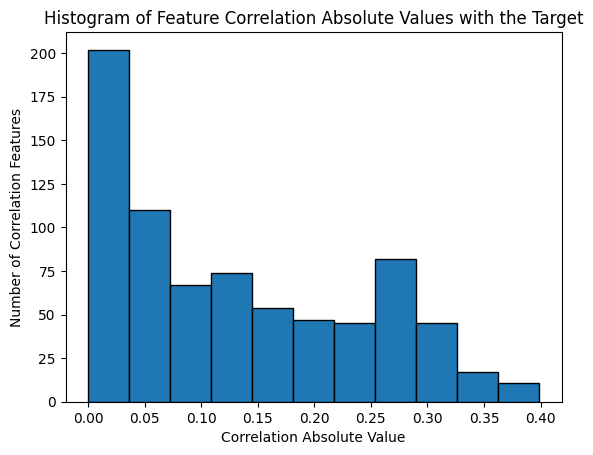

In [ ]:
# calculate correlations with target variable
df_features = df_raw.drop(TARGET_COL, axis=1)
correlations = abs(df_features.corrwith(df_raw[TARGET_COL]).sort_values().iloc[::-1])

# show distribution of feature correlation values with the target variable
# values range from (-0.4, 0.4)
plt.hist(correlations, bins='auto', edgecolor='black')
plt.xlabel("Correlation Absolute Value")
plt.ylabel("Number of Correlation Features")
plt.title(f"Histogram of Feature Correlation Absolute Values with the Target")

# **3. Speaker-Level Aggregation**

**Goal**:
Collapse multiple (3) recordings per speaker into one row per speaker by assigning row values to the mean of the 3 row values.

Why is aggregation necessary?
* It allows us to accurately assess our model. Dividing train/test splits by speaker ensures that test data is new & unseen to the ML model.

#### **Aggregation methods**
>
* `mean` → produces 1 feature per original feature (e.g., `Jitter__mean`).
* `mean_std` → produces 2 features per original feature (mean + std) (e.g., `Jitter__mean` and `Jitter__std`).

Correlation, F-score, MI, RFE, and tree-based methods will automatically decide whether `__mean` or `__std` is more predictive, adding interpretability.
* e.g. “variation in pitch (std), not average pitch, is most predictive of PD.”    

In [ ]:
# ===== Section 3: Aggregate to Speaker Level =====
def aggregate_by_speaker(df: pd.DataFrame, strategy: str = "mean") -> pd.DataFrame:

    assert strategy in {"mean", "mean_std", "robust"}
    # All columns are numeric, most are floats
    float_cols = df.select_dtypes(include='float64').columns
    int_cols = df.select_dtypes(include='int64').columns

    if strategy == "mean":
        float_feats = df.groupby(ID_COL)[float_cols].mean()
        float_feats.columns = [f"{c}__mean" for c in float_feats.columns]

        int_feats = df.groupby(ID_COL)[int_cols].mean().round().astype(int)

        for c in int_feats.columns:
          if c not in [ID_COL, TARGET_COL, "gender"]:
            int_feats[c].rename(f"{c}__mean")
        df_agg = pd.concat([int_feats, float_feats], axis=1)

    elif strategy == "mean_std":
        float_feats = df.groupby(ID_COL)[float_cols].agg(["mean", "std"])
        float_feats.columns = [f"{c[0]}__{c[1]}" for c in float_feats.columns]

        int_mean_feats = df.groupby(ID_COL)[int_cols].mean().round().astype(int)
        int_std_feats = df.groupby(ID_COL)[int_cols].std()
        for c in int_mean_feats.columns, int_std_feats:
          if c not in [ID_COL, TARGET_COL, "gender"]:
            int_feats[c].rename(f"{c[0]}__{c[1]}")

        df_agg = pd.concat([float_feats, int_mean_feats, int_std_feats], axis=1)

    print(f"Aggregated dataframe shape:", df_agg.shape)
    print("Speakers:", df_agg[ID_COL].nunique(), "| Class dist:", df_agg[TARGET_COL].value_counts())
    return df_agg

Aggregation by mean will be used for now, but the option to add standard deviation columns are left for future exploration.

In [ ]:
df_speaker = aggregate_by_speaker(df_raw, "mean")
df_speaker.head()

Aggregated dataframe shape: (252, 755)
Speakers: 252 | Class dist: class
1    188
0     64
Name: count, dtype: int64


,id,gender,numPulses,numPeriodsPulses,app_entropy_shannon_10_coef,class,PPE__mean,DFA__mean,RPDE__mean,meanPeriodPulses__mean,...,tqwt_kurtosisValue_dec_27__mean,tqwt_kurtosisValue_dec_28__mean,tqwt_kurtosisValue_dec_29__mean,tqwt_kurtosisValue_dec_30__mean,tqwt_kurtosisValue_dec_31__mean,tqwt_kurtosisValue_dec_32__mean,tqwt_kurtosisValue_dec_33__mean,tqwt_kurtosisValue_dec_34__mean,tqwt_kurtosisValue_dec_35__mean,tqwt_kurtosisValue_dec_36__mean
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,235,234,-3775111925,1,0.823387,0.696370,0.567250,0.008220,...,1.546500,1.561733,2.862000,12.293333,9.717500,9.055300,6.259100,4.021533,4.164333,22.961700
1,1,0,213,211,-3932364958,1,0.415637,0.793993,0.592453,0.008884,...,7.049367,4.918567,4.827133,6.117633,8.599667,5.737233,7.933133,5.490533,4.941833,4.467233
2,2,1,319,318,-7406612137,1,0.801973,0.619967,0.520563,0.006041,...,1.581967,41.129400,31.201933,14.584467,5.446800,3.462000,4.772067,9.176633,11.848100,5.552367
3,3,0,493,492,-17850173656,1,0.828707,0.626097,0.537183,0.003913,...,2.382533,1.677633,1.908400,2.842167,3.493867,3.282433,3.085267,3.184433,4.032933,22.773633
4,4,0,363,362,-17890362015,1,0.831287,0.779397,0.726717,0.005622,...,3.881267,4.104600,4.285233,2.953200,2.799933,2.645100,2.811367,7.268333,13.338833,63.766900


# **4. Feature Engineering**

**Goal:** Define feature selection methods used in later sections to reduce dimensionality, improve generalization, and increase interpretability.  

**Feature selection methods**:

- `drop_high_correlation` → removes redundant features with high pairwise correlation.  

- `fs_selectkbest_f` / `fs_selectkbest_mi` → keep top-k features by correlation, ANOVA F-score, or mutual information.  

- `fs_rfe_logreg_l2` / `fs_tree_importance` / `fs_l1_logreg` → model-based selectors using Logistic Regression, Random Forest, or L1 regularization.  

- `FEATURE_SELECTORS` → registry so we can call any method easily by name.

All methods return a **list of feature names** to keep. These will later be applied inside the train split only to avoid leakage.

Basically a bunch of functions with different feature engineering methods that will be used in GridSearchCV to test which yield the best result.

In [ ]:
# ===== Section 4: Feature-Selection Methods =====
def drop_high_correlation(X: pd.DataFrame, thresh: float = 0.9) -> List[str]:
    """
    Returns a list of column names to KEEP after dropping highly correlated
    features (absolute Pearson corr > thresh). Keeps the first occurrence.
    """
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thresh)]
    keep = [c for c in X.columns if c not in to_drop]
    return keep
"""
def fs_corr_topk(X: pd.DataFrame, y: pd.Series, k: int = 20) -> List[str]:
    """Top-k by absolute Pearson correlation with the label."""
    corrs = X.apply(lambda col: np.corrcoef(col, y)[0,1])
    order = corrs.abs().sort_values(ascending=False).index.tolist()
    return order[:min(k, len(order))]
"""
def fs_selectkbest_f(X: pd.DataFrame, y: pd.Series, k: int = 20) -> List[str]:
    """SelectKBest using ANOVA F-score (assumes approx. normal, linear separability)."""
    skb = SelectKBest(score_func=f_classif, k=min(k, X.shape[1]))
    skb.fit(X, y)
    idx = np.argsort(skb.scores_)[::-1][:min(k, X.shape[1])]
    return X.columns[idx].tolist()

def fs_selectkbest_mi(X: pd.DataFrame, y: pd.Series, k: int = 20) -> List[str]:
    """SelectKBest using Mutual Information (captures non-linear relationships)."""
    skb = SelectKBest(score_func=mutual_info_classif, k=min(k, X.shape[1]))
    skb.fit(X, y)
    idx = np.argsort(skb.scores_)[::-1][:min(k, X.shape[1])]
    return X.columns[idx].tolist()

def fs_rfe_logreg_l2(X: pd.DataFrame, y: pd.Series, k: int = 20) -> List[str]:
    """RFE with Logistic Regression (L2). Good linear baseline."""
    est = LogisticRegression(max_iter=2000, solver="liblinear", random_state=RANDOM_STATE)
    rfe = RFE(estimator=est, n_features_to_select=min(k, X.shape[1]), step=0.1)
    rfe.fit(X, y)
    return X.columns[rfe.cols_].tolist()

def fs_tree_importance(X: pd.DataFrame, y: pd.Series, k: int = 20) -> List[str]:
    """Tree-based selection via RandomForest importance (robust, non-linear)."""
    rf = RandomForestClassifier(
        n_estimators=400, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"
    )
    rf.fit(X, y)
    imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    return imp.index[:min(k, X.shape[1])].tolist()

def fs_l1_logreg(X: pd.DataFrame, y: pd.Series, C: float = 0.1) -> List[str]:
    """L1-penalized Logistic Regression for sparse feature selection."""
    lr = LR_L1(penalty="l1", C=C, solver="liblinear", max_iter=2000, random_state=RANDOM_STATE, class_weight="balanced")
    lr.fit(X, y)
    coef = pd.Series(lr.coef_[0], index=X.columns)
    keep = coef[coef != 0].index.tolist()
    return keep if keep else X.columns.tolist()  # fallback if nothing selected

# A registry so we can call by name in our training loop later
FEATURE_SELECTORS = {
    #"corr_top20":     lambda X,y: fs_corr_topk(X,y,k=20),
    "fscore_top20":   lambda X,y: fs_selectkbest_f(X,y,k=20),
    "mi_top20":       lambda X,y: fs_selectkbest_mi(X,y,k=20),
    "rfe_logreg20":   lambda X,y: fs_rfe_logreg_l2(X,y,k=20),
    "tree_top20":     lambda X,y: fs_tree_importance(X,y,k=20),
    "l1_logreg":      lambda X,y: fs_l1_logreg(X,y,C=0.1),
}

def apply_collinearity_prune(cols: List[str], X: pd.DataFrame, thresh: float=0.9) -> List[str]:
    """Drop highly correlated features after selection."""
    return drop_high_correlation(X[cols], thresh=thresh)

# **5. Train-Test Split**

Since the rows are aggregated, **no speaker (`id`) should appear in both train and test**.  

Outputs:
* `X_train`, `y_train`
* `X_test`, `y_test`  

The test set will be used **once at the end**. Model/feature/hyperparameter selection happens only on the training set.


In [ ]:
# ===== Section 5: Train-Test Split =====
X = df_speaker.drop(columns=[TARGET_COL])
y = df_speaker[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

print("=== Split Checks ===")
print("Total Speakers:", df_speaker[ID_COL].nunique())
print(f"Train speakers: {X_train[ID_COL].nunique()}, Test speakers: {X_test[ID_COL].nunique()}")

print("\n---> Note: PD speakers = 1, Non-PD = 0")
print("Train class distribution:", dict(Counter(y_train)))
print("Test  class distribution:", dict(Counter(y_test)))

X_train = X_train.drop(columns=["id"])
X_test = X_test.drop(columns=ID_COL)

=== Split Checks ===
Total Speakers: 252
Train speakers: 189, Test speakers: 63

---> Note: PD speakers = 1, Non-PD = 0
Train class distribution: {1: 141, 0: 48}
Test  class distribution: {0: 16, 1: 47}


In [ ]:
X_train.head()

,gender,numPulses,numPeriodsPulses,app_entropy_shannon_10_coef,PPE__mean,DFA__mean,RPDE__mean,meanPeriodPulses__mean,stdDevPeriodPulses__mean,locPctJitter__mean,...,tqwt_kurtosisValue_dec_27__mean,tqwt_kurtosisValue_dec_28__mean,tqwt_kurtosisValue_dec_29__mean,tqwt_kurtosisValue_dec_30__mean,tqwt_kurtosisValue_dec_31__mean,tqwt_kurtosisValue_dec_32__mean,tqwt_kurtosisValue_dec_33__mean,tqwt_kurtosisValue_dec_34__mean,tqwt_kurtosisValue_dec_35__mean,tqwt_kurtosisValue_dec_36__mean
id,,,,,,,,,,,,,,,,,,,,,
22,0,467,466,-16059608390,0.825520,0.615327,0.404377,0.004137,0.000048,0.000660,...,67.858867,63.947367,59.764400,57.174933,58.226567,56.705733,50.603367,49.641167,44.715067,91.377533
169,1,371,367,-3733028593,0.592123,0.710687,0.692300,0.005199,0.002323,0.004477,...,3.753367,3.320933,5.539300,8.650500,8.226267,8.729633,17.880800,41.315033,39.225767,94.838167
148,0,327,326,-8249180158,0.587827,0.693483,0.486507,0.005914,0.000893,0.002487,...,1.581167,1.552600,32.779600,23.541300,12.024367,6.946367,7.501100,8.569533,7.004633,5.352967
244,0,369,368,-9966953991,0.658227,0.692450,0.527063,0.005094,0.000431,0.001060,...,23.630300,6.390333,3.863400,3.595400,3.697233,3.186367,2.679700,2.911233,2.793200,4.350067
107,1,256,255,-4592257265,0.839447,0.754393,0.300450,0.007519,0.000054,0.001407,...,10.109100,6.064833,5.584867,4.066200,3.472000,5.516000,8.790233,9.708467,6.989600,26.404267


In [ ]:
X_test.head()

,gender,numPulses,numPeriodsPulses,app_entropy_shannon_10_coef,PPE__mean,DFA__mean,RPDE__mean,meanPeriodPulses__mean,stdDevPeriodPulses__mean,locPctJitter__mean,...,tqwt_kurtosisValue_dec_27__mean,tqwt_kurtosisValue_dec_28__mean,tqwt_kurtosisValue_dec_29__mean,tqwt_kurtosisValue_dec_30__mean,tqwt_kurtosisValue_dec_31__mean,tqwt_kurtosisValue_dec_32__mean,tqwt_kurtosisValue_dec_33__mean,tqwt_kurtosisValue_dec_34__mean,tqwt_kurtosisValue_dec_35__mean,tqwt_kurtosisValue_dec_36__mean
id,,,,,,,,,,,,,,,,,,,,,
45,0,315,314,-6999611603,0.758003,0.629090,0.555173,0.006138,0.000087,0.001540,...,2.384600,121.424667,100.645600,82.953433,68.133367,53.745367,39.676133,26.601333,19.587267,9.326100
142,1,427,425,-22332174412,0.314347,0.706690,0.460290,0.003457,0.000151,0.001807,...,73.599867,75.932200,51.463867,32.379633,30.795267,48.257833,39.646800,29.581200,27.464033,87.408733
103,0,319,318,-14412185664,0.695677,0.705133,0.593263,0.007010,0.000683,0.002060,...,36.123100,27.244533,7.919000,3.229800,3.667867,3.031700,2.823633,3.089800,3.133967,3.184200
81,1,102,100,-8394976000,0.593047,0.604230,0.579613,0.006036,0.000869,0.001590,...,3.545267,2.634533,2.867233,3.859033,3.003233,3.091267,3.768533,3.542300,2.877367,5.549933
251,0,354,353,-9178814091,0.844917,0.745653,0.476707,0.005475,0.000065,0.000820,...,51.301267,44.571367,26.370167,14.782567,4.455833,2.621600,2.514667,3.409800,2.936467,3.969400


# **6. Model Search: selector + sampler + model (StratifiedKFold CV)**

We build a single `ImbPipeline` with slots for:
- **Feature selector** (fit on train fold only via a custom wrapper around our Section 4 selectors),

- **Sampler** (`None` / `SMOTE` / `SMOTEENN`, applied train-only),

- **Model** (Logistic Regression, Random Forest, XGBoost),

- Optional **Scaler** (only helpful for linear models).

We then run `GridSearchCV` with **StratifiedKFold** (imbalanced target class) and **multi-metric scoring**, using **PD Recall (sensitivity)** as the `refit` metric to prioritize **minimizing false negatives**.

The result is a **best full pipeline** and a **CV results table** for comparison.


(A) Wrap Section 4 selectors so they fit inside a Pipeline safely (fit on train fold only)

In [59]:
# ===== Section 6: Model Search with StratifiedKFold CV =====
class FitOnTrainSelector(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible wrapper for our custom feature selectors from Section 4.
    - selector_name: key in FEATURE_SELECTORS
    - prune_thresh: correlation threshold for pruning
    """
    def __init__(self, selector_name: str, prune_corr: bool = False, prune_thresh: float = 0.9):
        self.selector_name = selector_name
        self.prune_corr = prune_corr
        self.prune_thresh = prune_thresh
        self.cols_ = None

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        assert self.selector_name in FEATURE_SELECTORS, f"Unknown selector: {self.selector_name}"
        # 1) run the chosen selector on TRAIN ONLY
        selected = FEATURE_SELECTORS[self.selector_name](X, y)

        self.cols_ = selected
        return self

    def transform(self, X: pd.DataFrame):
        assert self.cols_ is not None, "Fit the selector before transform."
        # Keep only selected columns (order preserved)
        return X.loc[:, self.cols_].copy()

    def get_support(self):
        """Helper to inspect selected columns."""
        return self.cols_

(B) Define the base pipeline with slots we will populate via param_grid

In [60]:
pipe = ImbPipeline(steps=[
    ("select", "passthrough"),             # FitOnTrainSelector(...) or passthrough
    ("scale", "passthrough"),              # StandardScaler() or passthrough
    ("sampler", "passthrough"),            # None / SMOTE / SMOTEENN
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

(C) Candidate recipes (param grids) for multiple models

In [62]:
param_grid: List[Dict] = [

    # Logistic Regression recipes
    {
        "select": [
           FitOnTrainSelector("fscore_top20"),
           FitOnTrainSelector("mi_top20"),
           FitOnTrainSelector("l1_logreg", prune_corr=True, prune_thresh=0.9),
        ],
        "scale": [StandardScaler(with_mean=True), "passthrough"],  # scaling can help LR; we test both
        "sampler": ["passthrough", SMOTE(random_state=RANDOM_STATE), SMOTEENN(random_state=RANDOM_STATE)],
        "model": [LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", random_state=RANDOM_STATE)],
        "model__C": [0.1, 1.0, 10.0]
    },

    # Random Forest recipes
    {
        "select": [
            FitOnTrainSelector("tree_top20"),
            FitOnTrainSelector("mi_top20", prune_corr=True),
        ],
        "scale": ["passthrough"],  # trees don't need scaling
        "sampler": ["passthrough", SMOTE(random_state=RANDOM_STATE), SMOTEENN(random_state=RANDOM_STATE)],
        "model": [RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE)],
        "model__n_estimators": [400, 800],
        "model__max_depth": [None, 8, 16],
        "model__min_samples_leaf": [1, 3]
    },

    # XGBoost recipes
    {
        "select": [
            FitOnTrainSelector("mi_top20"),
            FitOnTrainSelector("tree_top20"),
            FitOnTrainSelector("rfe_logreg20", prune_corr=True)
        ],
        "scale": ["passthrough"],  # trees don't need scaling
        "sampler": ["passthrough", SMOTE(random_state=RANDOM_STATE), SMOTEENN(random_state=RANDOM_STATE)],
        "model": [xgb.XGBClassifier(
            eval_metric="logloss",
            random_state=RANDOM_STATE,
            tree_method="gpu_hist",
            n_estimators=400,
        )],
        "model__max_depth": [3, 5],
        "model__learning_rate": [0.05, 0.1],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0],z
    }
]

(D) Multi-metric scoring; refit on PD recall (sensitivity) to minimize false negatives


In [63]:
scoring = {
    "pd_recall": make_scorer(recall_score, pos_label=POS_LABEL),
    "roc_auc": "roc_auc",
    "f1": "f1",                       # for PD (pos_label=1)
    "precision": "precision",
    "accuracy": "accuracy",
    # Specificity = recall of the negative class; we’ll compute later on test for clarity
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="pd_recall",               # choose the recipe that best recovers PD cases
    cv=cv,
    n_jobs=-1,
    verbose=3,
    return_train_score=True
)

(E) Run the search on TRAINING dataset ONLY

In [ ]:
gs.fit(X_train, y_train)

best_pipeline = gs.best_estimator_
best_params = gs.best_params_
print("\nBest recipe (by mean CV PD recall):")
for k, v in best_params.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best recipe (by mean CV PD recall):
  model: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
  model__max_depth: None
  model__min_samples_leaf: 1
  model__n_estimators: 400
  sampler: passthrough
  scale: passthrough
  select: FitOnTrainSelector(prune_corr=True, selector_name='mi_top20')


(F) Summarize CV results into a tidy table

In [ ]:
cvres = pd.DataFrame(gs.cv_results_)

# Keep key columns
keep_cols = [
    "mean_test_pd_recall", "std_test_pd_recall",
    "mean_test_roc_auc", "mean_test_f1", "mean_test_precision", "mean_test_accuracy",
    "param_select", "param_scale", "param_sampler", "param_model",
    "param_model__C", "param_model__n_estimators", "param_model__max_depth",
    "param_model__min_samples_leaf", "param_model__learning_rate",
    "param_model__subsample", "param_model__colsample_bytree",
]
present_cols = [c for c in keep_cols if c in cvres.columns]
cv_table = cvres[present_cols].sort_values(
    by=["mean_test_pd_recall", "mean_test_roc_auc"], ascending=[False, False]
).reset_index(drop=True)

print("\nTop CV rows (by PD recall then ROC-AUC):")
display(cv_table.head(10))

# Store for later sections
MODEL_SEARCH_RESULTS = {
    "grid_search": gs,
    "best_pipeline": best_pipeline,
    "cv_table": cv_table
}

#### **The best hyperparameter recipe is:**

- Model = XGBoost

- Features = top 20 by tree importance

- No scaling, no resampling

- XGB params = `max_depth=5, learning_rate=0.05, subsample=0.8, colsample_bytree=1.0, n_estimators=400`

#### **Note on Prioritizing Recall**

> In this health screening task, we treat **PD = positive class**.  
> - **Recall (Sensitivity)** = TP / (TP + **FN**) → *How many actual PD cases we correctly catch.*  
>   - **False Negative (FN)** = a PD patient missed → **worst outcome** for screening (delayed care).
> - **Precision (PPV)** = TP / (TP + **FP**) → *Of those we flag as PD, how many truly are PD.*  
>   - **False Positive (FP)** = unnecessary follow-up/anxiety/cost, still important but less harmful than FN.
>
> **Policy for this project:**  
> - Use **PD Recall as the primary selection metric** (`refit="pd_recall"`) to minimize **missed PD cases**.  
> - Track **Precision, ROC-AUC, Accuracy, F1** as secondary metrics to avoid a model that flags everyone.  
> - Later (Section 7), we can **tune the decision threshold** to balance Recall vs. Precision for the clinical context.


# **7. Final Evaluation on Test Set + Threshold Tuning**

We evaluate the **best pipeline** on the untouched test speakers.  

We report: **Recall (PD)**, **Precision**, **Specificity**, **F1**, **ROC-AUC**, confusion matrix, and curves.  

## **x Threshold Tuning (Weighted Utility Approach)**

In medical screening, using the default threshold of 0.50 can be risky:  

- **Recall (Sensitivity)** for PD → how many actual PD patients we correctly catch.  
- **Specificity** for Non-PD → how many healthy people we correctly recognize.  
- **Precision (PPV)** → of those flagged as PD, how many truly are PD.  

If we lower the threshold, we boost **Recall** (fewer PD patients missed) but risk hurting **Specificity** (more healthy people flagged).  

---

### Why Weighted Utility?
To balance both sides fairly, we combine **Recall** (for PD) and **Specificity** (for Non-PD) into a single score:  

\[
Utility = α x Recall_{PD} + β x Specificity
\]

- `α` (alpha) = weight on PD Recall (Sensitivity).  
- `β` (beta) = weight on Specificity (Non-PD recall).  
- `Precision floor` = a safeguard so we don’t accept thresholds where too many false alarms occur.  

By adjusting α and β, we tell the model what matters most:  
- In our case, we set **α = 0.7** and **β = 0.3**.  
- This means “catching PD patients” is about twice as important as “not bothering healthy people.”  

---

### What this section does
1. Sweep thresholds from 0 → 1 in small steps.  
2. Compute Recall, Specificity, Precision, F1, Accuracy at each threshold.  
3. Filter out thresholds where Precision < 0.65 (too many false alarms).  
4. Pick the threshold that **maximizes the weighted utility** score.  
5. Report the chosen threshold, its metrics, and a few nearby options for transparency.  
6. Visualize results with ROC, PR curves, and confusion matrix.  

---

This approach is flexible and closer to **real-world clinical decision-making**, where priorities differ by context.  
- If doctors value minimizing false negatives at all cost → raise α.  
- If unnecessary follow-ups are too expensive or stressful → raise β.  


=== Tuned threshold (weighted Recall & Specificity, Precision floor) ===
   threshold: 0.7870
     utility: 0.8169
   Recall_PD: 0.8723
 Specificity: 0.6875
Precision_PD: 0.8913
          F1: 0.8817
    Accuracy: 0.8254
          TP: 41.0000
          FP: 5.0000
          FN: 6.0000
          TN: 11.0000

=== Final metrics @ threshold = 0.79 ===
          TP: 41
          FP: 5
          FN: 6
          TN: 11
   Recall_PD: 0.8723
 Specificity: 0.6875
Precision_PD: 0.8913
          F1: 0.8817
    Accuracy: 0.8254
         FNR: 0.1277
         FPR: 0.3125

Nearby thresholds:


,threshold,Recall_PD,Specificity,Precision_PD,F1,Accuracy,TP,FP,FN,TN
784,0.784,0.87234,0.6250,0.872340,0.87234,0.809524,41,6,6,10
785,0.785,0.87234,0.6250,0.872340,0.87234,0.809524,41,6,6,10
786,0.786,0.87234,0.6250,0.872340,0.87234,0.809524,41,6,6,10
787,0.787,0.87234,0.6875,0.891304,0.88172,0.825397,41,5,6,11
788,0.788,0.87234,0.6875,0.891304,0.88172,0.825397,41,5,6,11
789,0.789,0.87234,0.6875,0.891304,0.88172,0.825397,41,5,6,11
790,0.790,0.87234,0.6875,0.891304,0.88172,0.825397,41,5,6,11


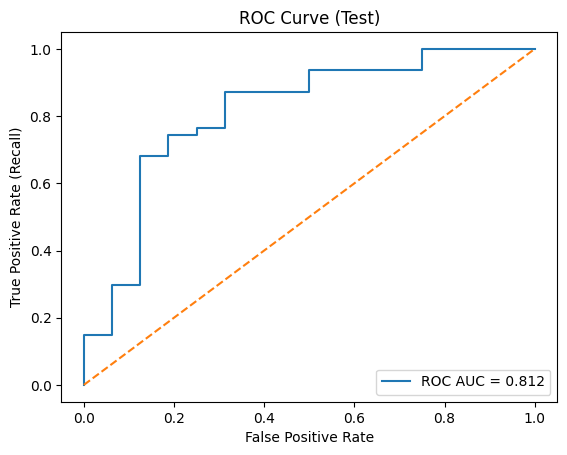

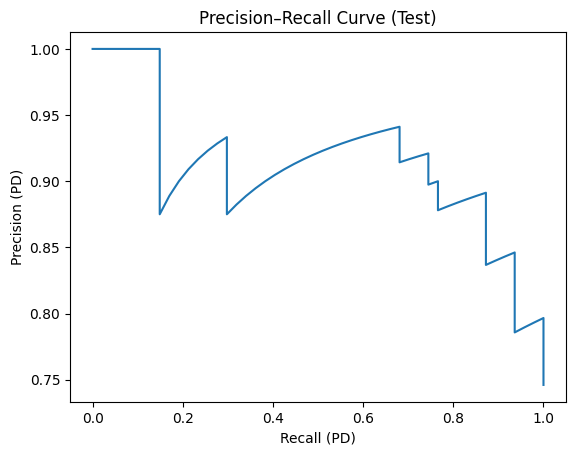

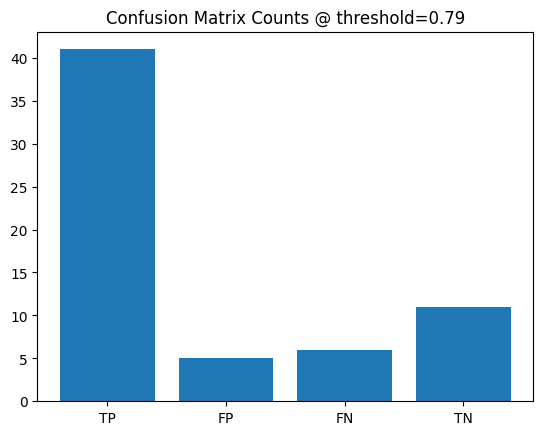

In [ ]:
# ===== Threshold tuning: weighted Recall + Specificity with a Precision floor =====

# Policy knobs (edit to clinical preference)
PRECISION_FLOOR = 0.65   # don't accept thresholds with PPV below this
ALPHA = 0.7             # weight on PD Recall (Sensitivity)
BETA  = 0.3             # weight on Specificity (Non-PD recall)

# 1) Sweep thresholds and collect metrics
ths = np.linspace(0.0, 1.0, 1001)
rows = [metrics_at_threshold(y_true, proba, thr=t, pos_label=POS_LABEL) for t in ths]
tune_df = pd.DataFrame(rows)

# 2) Keep thresholds that satisfy the precision floor (to avoid trivial, ultra-low thresholds)
candidates = tune_df[tune_df["Precision_PD"] >= PRECISION_FLOOR].copy()

# 3) Weighted utility of Recall (PD) and Specificity (Non-PD)
if len(candidates) > 0:
    candidates["utility"] = ALPHA * candidates["Recall_PD"] + BETA * candidates["Specificity"]
    # Choose the max utility; tight tie-breakers prefer higher Recall, then higher Specificity
    best = candidates.sort_values(["utility", "Recall_PD", "Specificity"], ascending=[False, False, False]).iloc[0]
    tuned = best.to_dict()

    print("\n=== Tuned threshold (weighted Recall & Specificity, Precision floor) ===")
    for k in ["threshold","utility","Recall_PD","Specificity","Precision_PD","F1","Accuracy","TP","FP","FN","TN"]:
        v = tuned[k]
        print(f"{k:>12}: {v:.4f}" if isinstance(v, float) else f"{k:>12}: {v}")
else:
    tuned = None
    print("\nNo threshold met the precision floor. Try lowering PRECISION_FLOOR slightly.")

# 4) Use tuned threshold if available; otherwise fall back to 0.50
use_thr = tuned["threshold"] if tuned else 0.50

# 5) Final evaluation at chosen threshold
chosen = metrics_at_threshold(y_true, proba, thr=use_thr, pos_label=POS_LABEL)
print(f"\n=== Final metrics @ threshold = {use_thr:.2f} ===")
for k in ["TP","FP","FN","TN","Recall_PD","Specificity","Precision_PD","F1","Accuracy","FNR","FPR"]:
    v = chosen[k]
    print(f"{k:>12}: {v:.4f}" if isinstance(v, float) else f"{k:>12}: {v}")

# 6) Show nearby thresholds (to visualize trade-offs around the chosen point)
def show_neighbors(df, thr, k=7):
    idx = (df["threshold"] - thr).abs().sort_values().index[:k]
    cols = ["threshold","Recall_PD","Specificity","Precision_PD","F1","Accuracy","TP","FP","FN","TN"]
    return df.loc[idx, cols].sort_values("threshold")

print("\nNearby thresholds:")
display(show_neighbors(tune_df, use_thr))

# 7) Quick plots
# ROC
fpr, tpr, _ = roc_curve(y_true, proba, pos_label=POS_LABEL)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_true, proba):.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test)")
plt.legend(loc="lower right")
plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(y_true, proba, pos_label=POS_LABEL)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall (PD)")
plt.ylabel("Precision (PD)")
plt.title("Precision–Recall Curve (Test)")
plt.show()

# Confusion matrix bars at chosen threshold
plt.figure()
plt.bar(["TP","FP","FN","TN"], [chosen["TP"], chosen["FP"], chosen["FN"], chosen["TN"]])
plt.title(f"Confusion Matrix Counts @ threshold={use_thr:.2f}")
plt.show()

## **Classification Report & Confusion Matrix for test set**

In [ ]:
# Classification report at chosen threshold
y_pred_chosen = (proba >= use_thr).astype(int)
print("\nClassification report @ chosen threshold:")
print(classification_report(y_true, y_pred_chosen, target_names=["Non-PD","PD"]))


Classification report @ chosen threshold:
              precision    recall  f1-score   support

      Non-PD       0.65      0.69      0.67        16
          PD       0.89      0.87      0.88        47

    accuracy                           0.83        63
   macro avg       0.77      0.78      0.77        63
weighted avg       0.83      0.83      0.83        63



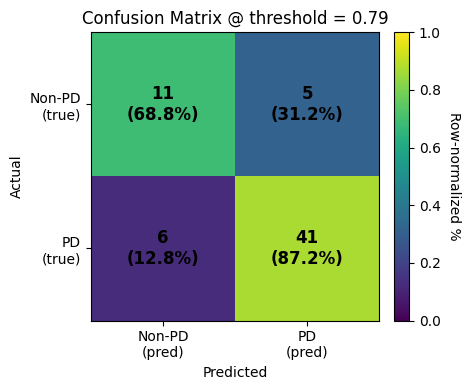

In [ ]:
# ===== Confusion Matrix Figure for Test Set=====
# Use tuned threshold if available, else 0.50
THRESHOLD = (tuned["threshold"] if isinstance(tuned, dict) and "threshold" in tuned else 0.50)

# Predictions at chosen threshold
y_pred = (proba >= THRESHOLD).astype(int)

# Confusion matrix (labels: 0=Non-PD, 1=PD)
labels = ["Non-PD", "PD"]
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# --- Plot confusion matrix with counts + row percentages ---
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, vmin=0, vmax=1)

# Ticks & labels
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels([f"{l}\n(pred)" for l in labels])
ax.set_yticklabels([f"{l}\n(true)" for l in labels])
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_title(f"Confusion Matrix @ threshold = {THRESHOLD:.2f}")

# Annotate each cell with counts and % (row-normalized)
for (i, j), val in np.ndenumerate(cm_norm):
    count = cm[i, j]
    txt = f"{count}\n({val*100:.1f}%)"
    ax.text(j, i, txt, ha="center", va="center", fontsize=12, fontweight="bold")

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Row-normalized %", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## **Comparisons on hyperparameter combos & across model families**

We used KFold cross-validation to compare hundreds of pipelines fairly. While GridSearchCV identified an XGBoost config with the highest recall, our aggregate results and test-set evaluation suggest Random Forest provides the best balance between sensitivity and overall discriminative power. This highlights both the utility and the limitations of CV-based model selection in small clinical datasets.

In [ ]:
# ===== Hyperparameter-level Comparison =====
# Pull all CV results
cvres = pd.DataFrame(gs.cv_results_).copy()

# ---------- Label helpers (full model names; compact sampler/selector/params) ----------
def full_model(x):
    s = str(x)
    if "LogisticRegression" in s: return "Logistic Regression"
    if "RandomForestClassifier" in s: return "Random Forest"
    if "XGBClassifier" in s: return "XGBoost"
    return s.split("(")[0]

def short_sampler(x):
    s = str(x)
    if "SMOTEENN" in s: return "SMOTE-ENN"
    if "SMOTE" in s:    return "SMOTE"
    if s == "passthrough": return "None"
    return s

def short_selector(x):
    s = str(x)
    m = re.search(r"selector_name='([^']+)'", s)
    key = m.group(1) if m else s
    mapping = {
        "mi_top20": "MI20", "fscore_top20": "F20", "rfe_logreg20": "RFE20",
        "l1_logreg": "L1", "tree_top20": "Tree20",
    }
    return mapping.get(key, key[:12])

def short_params(row):
    """Compact, model-specific hyperparams from the 'params' dict."""
    p = row["params"]
    mdl = row["Model"]
    if mdl == "Logistic Regression":
        C = p.get("model__C", None)
        return f"C={C}" if C is not None else ""
    if mdl == "Random Forest":
        n  = p.get("model__n_estimators", "")
        md = p.get("model__max_depth", "")
        ml = p.get("model__min_samples_leaf", "")
        return f"n={n} md={md} ml={ml}".strip()
    if mdl == "XGBoost":
        md = p.get("model__max_depth", "")
        lr = p.get("model__learning_rate", "")
        ss = p.get("model__subsample", "")
        cs = p.get("model__colsample_bytree", "")
        return f"md={md} lr={lr} ss={ss} cs={cs}".strip()
    return ""

=== Top 10 CV Configurations (sorted by PD Recall, then ROC-AUC) ===


,recipe,rec,roc,f1,prec,acc
0,XGBoost · Tree20 · None · md=5 lr=0.05 ss=0.8 cs=1.0,0.922,0.777,0.879,0.841,0.810
1,XGBoost · MI20 · None · md=3 lr=0.1 ss=0.8 cs=0.8,0.915,0.780,0.872,0.834,0.799
2,XGBoost · MI20 · None · md=3 lr=0.1 ss=1.0 cs=1.0,0.915,0.782,0.868,0.827,0.794
3,Random Forest · Tree20 · None · n=400 md=None ml=1,0.908,0.806,0.862,0.824,0.783
4,Random Forest · Tree20 · None · n=400 md=16 ml=1,0.908,0.806,0.862,0.824,0.783
5,Random Forest · Tree20 · None · n=800 md=None ml=1,0.908,0.804,0.862,0.824,0.783
6,Random Forest · Tree20 · None · n=800 md=16 ml=1,0.908,0.804,0.862,0.824,0.783
7,Random Forest · Tree20 · None · n=400 md=8 ml=1,0.908,0.803,0.862,0.824,0.783
8,Random Forest · Tree20 · None · n=800 md=8 ml=1,0.908,0.801,0.862,0.824,0.783
9,XGBoost · Tree20 · None · md=3 lr=0.05 ss=0.8 cs=1.0,0.908,0.780,0.871,0.839,0.799


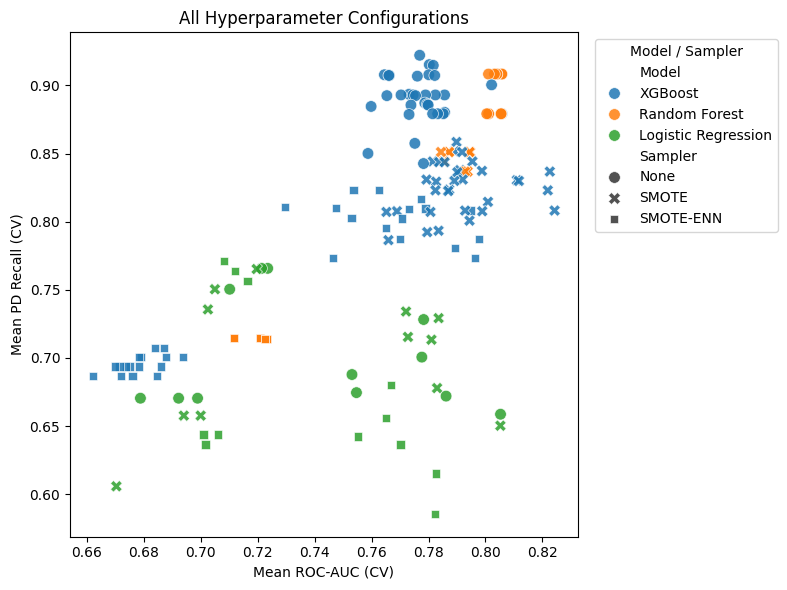

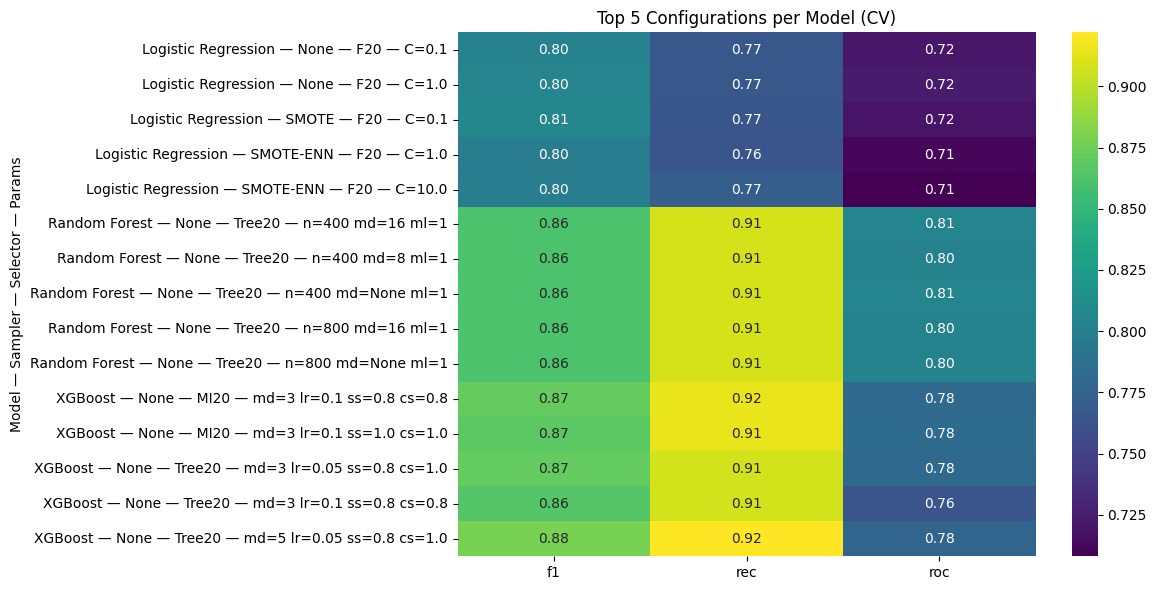

In [ ]:
# Map labels
cvres["Model"]    = cvres["param_model"].map(full_model)
cvres["Sampler"]  = cvres["param_sampler"].map(short_sampler)
cvres["Selector"] = cvres["param_select"].map(short_selector)

# Metrics (renamed for convenience)
cvres = cvres.rename(columns={
    "mean_test_pd_recall": "rec",
    "mean_test_roc_auc":   "roc",
    "mean_test_f1":        "f1",
    "mean_test_precision": "prec",
    "mean_test_accuracy":  "acc",
})

# Short param string
cvres["param_short"] = cvres.apply(short_params, axis=1)

# Tidy table we’ll use below
cols_keep = ["Model","Sampler","Selector","param_short","rec","roc","f1","prec","acc","params"]
cv_table_full = (
    cvres[cols_keep]
    .sort_values(["rec","roc"], ascending=[False, False])
    .reset_index(drop=True)
)

# One-line recipe string (nice in tables)
cv_table_full["recipe"] = (
    cv_table_full["Model"] + " · " +
    cv_table_full["Selector"] + " · " +
    cv_table_full["Sampler"] +
    ((" · " + cv_table_full["param_short"]).where(cv_table_full["param_short"] != "", ""))
).str.replace(r"\s+", " ", regex=True).str.strip(" ·")

print("=== Top 10 CV Configurations (sorted by PD Recall, then ROC-AUC) ===")
display(
    cv_table_full[["recipe","rec","roc","f1","prec","acc"]]
      .head(10)
      .style.format({"rec":"{:.3f}","roc":"{:.3f}","f1":"{:.3f}","prec":"{:.3f}","acc":"{:.3f}"})
)

# ---------- Visualization 1: Scatter (full model names; no point annotations) ----------
plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    data=cv_table_full,
    x="roc", y="rec",
    hue="Model", style="Sampler",
    s=70, alpha=0.85, edgecolor="white", linewidth=0.5
)
ax.set_xlabel("Mean ROC-AUC (CV)")
ax.set_ylabel("Mean PD Recall (CV)")
ax.set_title("All Hyperparameter Configurations")

# Legend outside; full model names shown there; keep plot clean (no text on points)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.02,1), loc="upper left",
          title="Model / Sampler", frameon=True)
plt.tight_layout()
plt.show()

# ---------- Visualization 2: Heatmap (top 5 configs per model) ----------
top_per_model = (
    cv_table_full
    .groupby("Model", group_keys=False)
    .apply(lambda d: d.head(5))
    .copy()
)

# Compact row index for readability
top_per_model["row_id"] = (
    top_per_model["Model"] + " — " +
    top_per_model["Sampler"] + " — " +
    top_per_model["Selector"] +
    ((" — " + top_per_model["param_short"]).where(top_per_model["param_short"] != "", ""))
).str.strip(" —")

pivot = top_per_model.pivot_table(
    index="row_id",
    values=["rec","roc","f1"],
    aggfunc="first"
)[["f1","rec","roc"]]  # column order

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt=".02f", cmap="viridis")
plt.title("Top 5 Configurations per Model (CV)")
plt.ylabel("Model — Sampler — Selector — Params")
plt.tight_layout()
plt.show()

# Keep for later sections if needed
MODEL_SEARCH_RESULTS["cv_table_full"] = cv_table_full

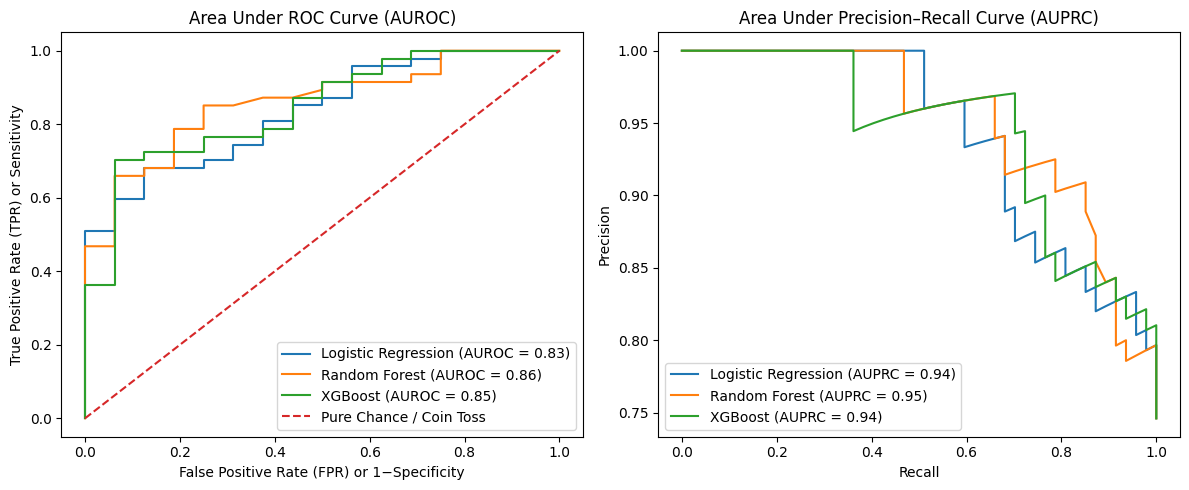

In [ ]:
# ===== Overlay ROC & PR curves by model family =====
cvres = pd.DataFrame(gs.cv_results_).copy()

def _label_model(x):
    s = str(x)
    if "LogisticRegression" in s: return "Logistic Regression"
    if "RandomForestClassifier" in s: return "Random Forest"
    if "XGBClassifier" in s: return "XGBoost"
    return s[:20]

cvres["model_label"] = cvres["param_model"].map(_label_model)

# pick the best CV row PER MODEL FAMILY (by ROC-AUC; or switch to mean_test_pd_recall)
best_rows = {}
for m in ["Logistic Regression","Random Forest","XGBoost"]:
    sub = cvres[cvres["model_label"] == m]
    if len(sub) == 0:
        continue
    best_idx = sub["mean_test_roc_auc"].idxmax()
    best_rows[m] = cvres.loc[best_idx, "params"]

curves = {}
for m, params in best_rows.items():
    # rebuild pipeline skeleton and set best params
    model_pipe = ImbPipeline(steps=pipe.steps)
    model_pipe.set_params(**params)

    # IMPORTANT: do NOT pass groups here; only CV needs groups
    model_pipe.fit(X_train, y_train)

    proba = model_pipe.predict_proba(X_test)[:, 1]
    # ROC
    fpr, tpr, _ = roc_curve(y_test, proba, pos_label=POS_LABEL)
    auc_roc = roc_auc_score(y_test, proba)
    # PR
    prec, rec, _ = precision_recall_curve(y_test, proba, pos_label=POS_LABEL)
    auc_pr = auc(rec, prec)

    curves[m] = {"fpr": fpr, "tpr": tpr, "auc_roc": auc_roc,
                 "prec": prec, "rec": rec, "auc_pr": auc_pr}

# Plot ROC (left) and PR (right)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
ax = axes[0]
for m, c in curves.items():
    ax.plot(c["fpr"], c["tpr"], label=f"{m} (AUROC = {c['auc_roc']:.2f})")
ax.plot([0, 1], [0, 1], linestyle="--", label="Pure Chance / Coin Toss")
ax.set_title("Area Under ROC Curve (AUROC)")
ax.set_xlabel("False Positive Rate (FPR) or 1−Specificity")
ax.set_ylabel("True Positive Rate (TPR) or Sensitivity")
ax.legend(loc="lower right")

# PR
ax = axes[1]
for m, c in curves.items():
    ax.plot(c["rec"], c["prec"], label=f"{m} (AUPRC = {c['auc_pr']:.2f})")
ax.set_title("Area Under Precision–Recall Curve (AUPRC)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="lower left")

plt.tight_layout()
plt.show()

## **SHAP Explainability**

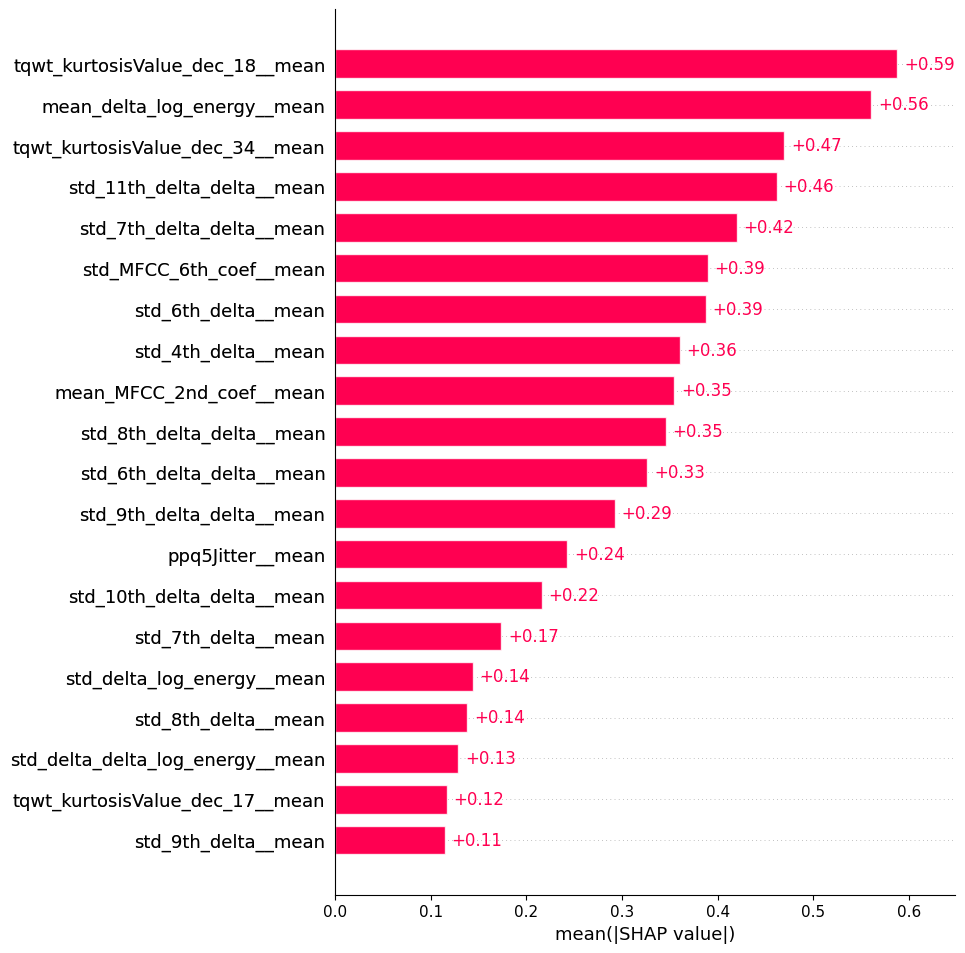

In [ ]:
# Get the best pipeline from GridSearchCV
best_pipeline = MODEL_SEARCH_RESULTS["best_pipeline"]

# Transform test features through pipeline
X_test_transformed = best_pipeline[:-1].transform(X_test)  # everything except the model
model = best_pipeline.named_steps["model"]

# Build SHAP explainer
background = shap.maskers.Independent(X_test_transformed, max_samples=100)
explainer = shap.Explainer(model, background)
shap_values = explainer(X_test_transformed)

# Plot with feature names
feat_names = best_pipeline.named_steps["select"].get_support()
shap_values.feature_names = feat_names
shap.plots.bar(shap_values, max_display=len(feat_names))